In [2]:
import pandas as pd
import numpy as np
from time import process_time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from custom_functions import *
from custom_models import *

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalMaxPooling1D, Conv1D, Dropout, GlobalAveragePooling1D,LSTM, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

# utils

In [51]:
def get_word_embeddings(filepath, vocab, embedding_dimension):

  word_embeddings = np.zeros((len(vocab) + 1, embedding_dimension))
#   word_embeddings = []
  embedding_file = open(filepath, "r", encoding = "utf8")
  count = 0
  nf = 0
  for line in embedding_file:
    line = line.split()
    word = line[0]
    if word in vocab:
        try:
          word_vector = np.asarray(line[1:], dtype = "float32")
          if len(word_vector) == embedding_dimension:
            word_embeddings[vocab[word]] = word_vector
          else:
            print('\nVector size does not match with embedding_dimension:\t', word_vector)
          count+=1
        except Exception as e:
            print(e)
            nf += 1
  print("Total word embeddings read: {}\n".format(count))
  print(nf)
  embedding_file.close()
  return word_embeddings   

# Text Classification Process Flow

1. Load train and test

In [4]:
# D_train = read_data()
# D_test = read_data()
data = read_data("../Arabic Sentiment Identification/dataset/sentimentscore_with_weights.csv")
print(data.shape)
D_train, D_test =  train_test_split(data ,test_size=0.2, random_state=42)
D_train = D_train.reset_index()
D_test = D_test.reset_index()

x_train = D_train['tweet_preprocessed']
y_train = D_train['sentiment'].values.tolist()
x_val = D_test['tweet_preprocessed']
y_val = D_test['sentiment'].values.tolist()

print('\ntraining data: {}\t validation data: {}'.format(len(x_train),len(x_val)),
      '\ntraining classes: {}\t validation classes: {} \n'.format(np.unique(y_val),np.unique(y_val)))


(12537, 13)

training data: 10029	 validation data: 2508 
training classes: ['NEG' 'NEU' 'POS']	 validation classes: ['NEG' 'NEU' 'POS'] 



2. Clean and Preprocess 

In [5]:
# Clean Text
# x_train = x_train.apply(lambda x : clean_text(x)).values.tolist()
# x_val = x_val.apply(lambda x : clean_text(x)).values.tolist()

x_train = x_train.values.tolist()
x_val = x_val.values.tolist()

# Preprocess Text


# Tokenize Text
tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(data['tweet_preprocessed'].values.tolist(),
                                                               x_train, x_val)

print('x_train_tokenized:',len(x_train_tokenized),'\nx_val_tokenized:',len(x_val_tokenized),
      "\nTotal Vocab: ",len(tokenizer.word_counts))

x_train_tokenized: 10029 
x_val_tokenized: 2508 
Total Vocab:  48543


In [6]:
# Pad Text
maximum_text_length = 50
padding_type = "post"
truncating_type = "post"

x_train_padded = pad_text_sequence(x_train_tokenized, maximum_text_length, padding_type, truncating_type)
x_val_padded = pad_text_sequence(x_val_tokenized, maximum_text_length, padding_type, truncating_type)

print('x_train_padded:',x_train_padded.shape,'\nx_val_padded',x_val_padded.shape)

x_train_padded: (10029, 50) 
x_val_padded (2508, 50)


3. Encode target variables (labels) to integers



In [7]:
y_train = get_label_encoding(y_train)
y_val = get_label_encoding(y_val)

print(y_train.shape, y_val.shape)

Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
(10029, 1) (2508, 1)


# Input 1:  Word Embeddings

In [8]:
# Load word embeddings from file
vocab = tokenizer.word_index
embedding_dimension = 300
embeddings_file = "../Arabic Sentiment Identification/word embeddings/fasttext_model-skipgram_dim-300.vec"

embedding_matrix = get_word_embeddings(embeddings_file,vocab,embedding_dimension)

# Get sentence embeddings

# Validate embedding_matrix shape
print("Total Vocab:",len(vocab), "\nEmbeddings:",embedding_matrix.shape[0] -1 )

Total word embeddings read: 47863

Total Vocab: 48544 
Embeddings: 48544


# Input 2: Sentiment Features

In [9]:
def get_sentiment_matrix(df):
    sentiment_matrix  = np.zeros((len(df), 4), dtype='float64')
    
    for i in range(len(df)):
        try:
            sentiment_matrix[i] = np.array([1,df['NEU_WEIGHTS'][i],df['POSNEG_WEIGHTS'][i], df['SEN_SCORE'][i]], dtype='float64')
        except:
            print(i)
    return sentiment_matrix

In [10]:
sentiment_train = get_sentiment_matrix(D_train)
sentiment_val = get_sentiment_matrix(D_test)

print("Sentiment Input (Train): {}\nSentiment Input (Test): {}".format(sentiment_train.shape, sentiment_val.shape))

Sentiment Input (Train): (10029, 4)
Sentiment Input (Test): (2508, 4)


In [11]:
i1 = Input(shape = (sentiment_train.shape[1]))
d1 = Dense(64, activation = "relu")(i1)
d2 = Dense(32, activation = "relu")(d1)
d3 = Dense(3, activation = "softmax")(d2)

m = Model(inputs = i1, outputs= d2)
m.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

m.summary()

h = m.fit(sentiment_train, y_train, epochs=10, validation_data = (sentiment_val, y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
_________________________________________________________________
Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 2s 230us/sample - loss: 1.4935 - acc: 0.6878 - val_loss: 0.4071 - val_acc: 0.9147
Epoch 2/10
10029/10029 [==============================] - 1s 89us/sample - loss: 0.3845 - acc: 0.9059 - val_loss: 0.3007 - val_acc: 0.9207
Epoch 3/10
10029/10029 [==============================] - 1s 

# Multi-Channel Bi-LSTM

In [12]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

#--------------------------------------------------------------------------------------------------------------------#

# Define model hyperparameters
input_length1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

input2 = sentiment_train
input_length2 = input2.shape[1]

output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length1,"x",embedding_dimension)
print('Shape of Input layer 1: ',len(x_train),"x",embedding_dimension)
print('Shape of Input layer 2: ',len(x_train),"x",input_length2)

print("Output classes: ",output_dimension)
#--------------------------------------------------------------------------------------------------------------------#

# Define Input Channel 1

Input_layer1 = Input(shape = (input_length1,))
Embedding_layer1 = Embedding(input_length = input_length1, input_dim = embedding_vocab1, output_dim = embedding_dimension1,
                             weights = [embedding_matrix], trainable = False)(Input_layer1)

LSTM_layer1 = Bidirectional(LSTM(128, return_sequences = True))(Embedding_layer1)
Max_Pool_1 = GlobalMaxPooling1D()(LSTM_layer1)
Dense1 = Dense(64, activation = "relu")(Max_Pool_1)
dropout_Dense1 = Dropout(0.25)(Dense1)

# Input Channel 2
Input_layer2 = Input(shape= (input_length2,))
Dense2 = Dense(64, activation = "relu")(Input_layer2)

# Concatentate Channels
Concat_layer= concatenate([dropout_Dense1, Dense2])

# Define output layer
Output_layer = Dense(output_dimension, activation = "softmax")(Concat_layer)


# Compile model
model = Model(inputs = [Input_layer1, Input_layer2], outputs = Output_layer)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics= ["acc"])
model.summary()

Shape of each Input Sentence:  50 x 300
Shape of Input layer 1:  10029 x 300
Shape of Input layer 2:  10029 x 4
Output classes:  3
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      14563500    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      439296      embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0      

In [18]:
# plot_model(model, show_shapes=True)

In [14]:
model_history = model.fit([x_train_padded, sentiment_train],
                         y_train, epochs=10, batch_size= 128, verbose=1, validation_data = ([x_val_padded,sentiment_val],
                                                                                            y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 53s 5ms/sample - loss: 0.3062 - acc: 0.8981 - val_loss: 0.1804 - val_acc: 0.9478
Epoch 2/10
10029/10029 [==============================] - 46s 5ms/sample - loss: 0.1735 - acc: 0.9433 - val_loss: 0.1650 - val_acc: 0.9502
Epoch 3/10
10029/10029 [==============================] - 44s 4ms/sample - loss: 0.1473 - acc: 0.9505 - val_loss: 0.1317 - val_acc: 0.9553
Epoch 4/10
10029/10029 [==============================] - 44s 4ms/sample - loss: 0.1213 - acc: 0.9589 - val_loss: 0.1261 - val_acc: 0.9533
Epoch 5/10
10029/10029 [==============================] - 42s 4ms/sample - loss: 0.1063 - acc: 0.9654 - val_loss: 0.1255 - val_acc: 0.9541
Epoch 6/10
10029/10029 [==============================] - 46s 5ms/sample - loss: 0.0933 - acc: 0.9680 - val_loss: 0.1289 - val_acc: 0.9593
Epoch 7/10
10029/10029 [==============================] - 48s 5ms/sample - loss: 0.0800 - acc: 0.9738 - val_loss: 0.1

6. Evaluate Model

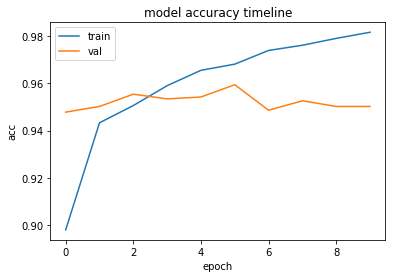

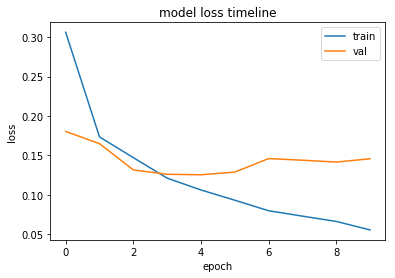


Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.96      0.96       924
           1       0.96      0.95      0.96      1172
           2       0.92      0.92      0.92       412

    accuracy                           0.95      2508
   macro avg       0.94      0.94      0.94      2508
weighted avg       0.95      0.95      0.95      2508



In [17]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

In [ ]:
# save model

# Multi-Channel CNN

In [47]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
gmp = GlobalMaxPooling1D()(c1)
c1_do = Dropout(0.3)(gmp)
# max_pool1 = MaxPooling1D(pool_size=3)(c1_do)


d1 = Dense(64, activation="relu")(c1_do)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
d2 = Dense(64, activation = "relu")(i2)

# Merge Channels
merged = concatenate([d1,d2])

#output
output = Dense(output_dim, activation = "softmax")(merged)


# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [49]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs = 10, batch_size = 64,
                                  validation_data = ([x_val_padded, sentiment_val],y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 19s 2ms/sample - loss: 0.3053 - acc: 0.8882 - val_loss: 0.1847 - val_acc: 0.9402
Epoch 2/10
10029/10029 [==============================] - 17s 2ms/sample - loss: 0.1663 - acc: 0.9427 - val_loss: 0.1505 - val_acc: 0.9494
Epoch 3/10
10029/10029 [==============================] - 17s 2ms/sample - loss: 0.1266 - acc: 0.9589 - val_loss: 0.1456 - val_acc: 0.9498
Epoch 4/10
10029/10029 [==============================] - 16s 2ms/sample - loss: 0.0969 - acc: 0.9691 - val_loss: 0.1535 - val_acc: 0.9478
Epoch 5/10
10029/10029 [==============================] - 18s 2ms/sample - loss: 0.0806 - acc: 0.9747 - val_loss: 0.1801 - val_acc: 0.9390
Epoch 6/10
10029/10029 [==============================] - 17s 2ms/sample - loss: 0.0714 - acc: 0.9785 - val_loss: 0.1623 - val_acc: 0.9442
Epoch 7/10
10029/10029 [==============================] - 16s 2ms/sample - loss: 0.0618 - acc: 0.9810 - val_loss: 0.1

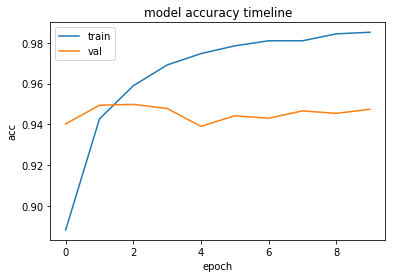

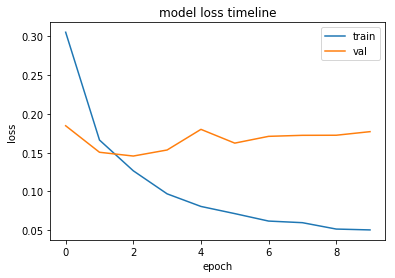


Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.95      0.95       924
           1       0.95      0.95      0.95      1172
           2       0.91      0.93      0.92       412

    accuracy                           0.95      2508
   macro avg       0.94      0.94      0.94      2508
weighted avg       0.95      0.95      0.95      2508



In [50]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# Multi-Channel CNN-BiLSTM

In [ ]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

#--------------------------------------------------------------------------------------------------------------------#

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
c1_do = Dropout(0.3)(c1)
max_pool1 = MaxPooling1D(pool_size=3)(c1_do)

b1 = Bidirectional(LSTM(128, dropout = 0.3, return_sequences = True, ))(max_pool1)
gmp1 = GlobalMaxPooling1D()(b1)

d1 = Dense(64, activation = "relu")(gmp1)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
d2 = Dense(64, activation = "relu")(i2)

# Merge channels
merge = concatenate([d1, d2])

# Output layer
output = Dense(output_dim, activation = "softmax")(merge)


#---------------------------------------------------------------------------------------------------------------------#

# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [25]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs=10, verbose = 1, batch_size=64,
                         validation_data=([x_val_padded,sentiment_val], y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 51s 5ms/sample - loss: 0.2289 - acc: 0.9243 - val_loss: 0.1488 - val_acc: 0.9545
Epoch 2/10
10029/10029 [==============================] - 33s 3ms/sample - loss: 0.1445 - acc: 0.9519 - val_loss: 0.1264 - val_acc: 0.9589
Epoch 3/10
10029/10029 [==============================] - 32s 3ms/sample - loss: 0.1235 - acc: 0.9574 - val_loss: 0.1354 - val_acc: 0.9533
Epoch 4/10
10029/10029 [==============================] - 31s 3ms/sample - loss: 0.1035 - acc: 0.9652 - val_loss: 0.1182 - val_acc: 0.9593
Epoch 5/10
10029/10029 [==============================] - 32s 3ms/sample - loss: 0.0892 - acc: 0.9706 - val_loss: 0.1474 - val_acc: 0.9458
Epoch 6/10
10029/10029 [==============================] - 32s 3ms/sample - loss: 0.0834 - acc: 0.9722 - val_loss: 0.1247 - val_acc: 0.9553
Epoch 7/10
10029/10029 [==============================] - 32s 3ms/sample - loss: 0.0685 - acc: 0.9771 - val_loss: 0.1

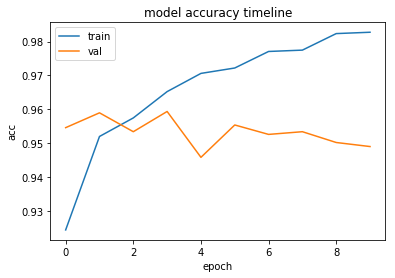

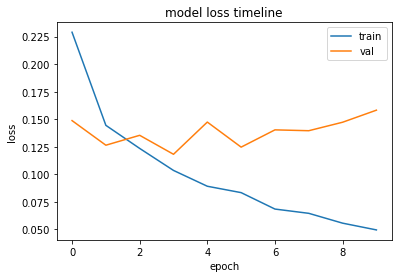


Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.96      0.96       924
           1       0.95      0.95      0.95      1172
           2       0.95      0.91      0.93       412

    accuracy                           0.95      2508
   macro avg       0.95      0.94      0.94      2508
weighted avg       0.95      0.95      0.95      2508



In [26]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))